In [1]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import tensorflow
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
import torchvision.models as models
import torch
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as v2
from torch.utils.data import DataLoader
import torchvision.datasets as datasets


2024-04-18 22:07:32.476303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 22:07:32.476396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 22:07:32.599924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
IMAGE_SIZE = 224
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
transform_test = v2.Compose(
    [v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor(),
     v2.Normalize(mean, std)])

transform_train = v2.Compose(
    [v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.RandomRotation(20),
        v2.RandomHorizontalFlip(0.1),
        v2.ColorJitter(brightness = 0.1, contrast=0.1, saturation=0.1),
        v2.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        v2.ToTensor(),
        v2.Normalize(mean, std),
        v2.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)




100%|██████████| 170498071/170498071 [00:11<00:00, 14347692.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
batch_size=64

trainLoader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testLoader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=True, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(next(iter(testLoader))[0].shape)

torch.Size([64, 3, 224, 224])


In [5]:
class HiddenLayer(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.premodel = pretrained_model
        self.new_layer = nn.Sequential(
                nn.Linear(1000, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 10)
                )

    def forward(self, x):
        out = self.premodel(x)
        out_new_layer = self.new_layer(out)
        return out_new_layer


resnet = models.resnet50(pretrained=True)

x = torch.randn((2, 3, 224, 224))

print(x.shape)
model_check = HiddenLayer(resnet)
model_check.load_state_dict(torch.load("/kaggle/input/resnet50/CIFAR_end_hll.pt"))
model_check.eval()
print(model_check.forward(x).shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


torch.Size([2, 3, 224, 224])
torch.Size([2, 10])


In [6]:
model_check.to(device)
features = []

for x, y in tqdm(trainLoader):
    x = x.to(device)
    with torch.no_grad():
        output = model_check.forward(x)
    features.append(output)

features_tensor = torch.cat(features, dim=0)
print(features_tensor.shape)

100%|██████████| 782/782 [01:45<00:00,  7.44it/s]

torch.Size([50000, 10])


In [7]:
model_check.to(device)
features_test = []

for x, y in tqdm(testLoader):
    x = x.to(device)
    with torch.no_grad():
        output = model_check.forward(x)
    features_test.append(output)

features_tensor_test = torch.cat(features_test, dim=0)
print(features_tensor_test.shape)

100%|██████████| 157/157 [00:16<00:00,  9.51it/s]

torch.Size([10000, 10])


In [8]:
features  = features_tensor
features_test = features_tensor_test

In [9]:
output_file = 'extracted_features_test.pt'

# Save the extracted features tensor to file
torch.save(features_tensor_test, output_file)
print(f"Extracted features saved to '{output_file}'")

Extracted features saved to 'extracted_features_test.pt'


In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch1 = unpickle("/kaggle/working/data/cifar-10-batches-py/data_batch_1")
batch2 = unpickle("/kaggle/working/data/cifar-10-batches-py/data_batch_2")
batch3 = unpickle("/kaggle/working/data/cifar-10-batches-py/data_batch_3")
batch4 = unpickle("/kaggle/working/data/cifar-10-batches-py/data_batch_4")
batch5 = unpickle("/kaggle/working/data/cifar-10-batches-py/data_batch_5")
test_batch = unpickle("/kaggle/working/data/cifar-10-batches-py/test_batch")

In [11]:
train_batch = [batch1,batch2,batch3,batch4,batch5]
train_y = []
train_x = []
for batch in train_batch:
  print(batch[b'batch_label'])
  y_data = batch[b'labels']
  x_data = batch[b'data']
  x_data = x_data.reshape(len(x_data),3,32,32).transpose(0,2,3,1)

  for i in range(len(y_data)):
    train_y.append(y_data[i])
    
  for i in range(len(y_data)):
    train_x.append(x_data[i])


b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'


In [12]:
test_y = []
test_x = []
y_data = test_batch[b'labels']

x_data = test_batch[b'data']
x_data = x_data.reshape(len(x_data),3,32,32).transpose(0,2,3,1)

for i in range(len(y_data)):
  test_y.append(y_data[i])
for i in range(len(y_data)):
  test_x.append(x_data[i])

In [13]:
resnet_train_data = []
for i in range(len(features)):
  resnet_train_data.append((features_tensor[i],train_y[i]))
resnet_test_data = []
for i in range(len(features_tensor_test)):
  resnet_test_data.append((features_tensor_test[i],test_y[i]))

In [14]:
import torch
from tqdm import tqdm

# Assuming trainLoader is your DataLoader containing image data and labels
class_images_dict = {}


# Iterate over the trainLoader with tqdm to collect images by class
for batch_idx, (images, labels) in enumerate(tqdm(resnet_train_data, desc="Creating Class Images Dictionary")):
    # Move images and labels to GPU if available
    images = images
    labels = labels
    class_name = labels
    
    if class_name not in class_images_dict:
        class_images_dict[class_name] = []
    class_images_dict[class_name].append(batch_idx)


Creating Class Images Dictionary: 100%|██████████| 50000/50000 [00:00<00:00, 892819.22it/s]


In [ ]:
print(class_images_dict[3])  [4642, 2087, 3465]

In [50]:
import torch
from sklearn.metrics.pairwise import euclidean_distances
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# Define the transformation for the test image
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load and preprocess the test image
image_path = "/kaggle/input/blackp/download (1).jpeg"
image_pil = Image.open(image_path)
image_resized = image_pil.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
image_tensor = transform(image_resized).unsqueeze(0)  # Add batch dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)

# Perform inference on the transformed test image
with torch.no_grad():
    z = model_check(image_tensor)
    _, test_label = torch.max(z, 1)

# Get indices of images belonging to the predicted class
class_indices = class_images_dict[test_label.item()]
class_features = [(features[idx], idx) for idx in class_indices]

# Convert test features to NumPy array
test_features = z.cpu().detach().numpy()

# Compute Euclidean distances between test image features and class features
distances = euclidean_distances(test_features, [f[0].cpu() for f in class_features])

# Find the indices of closest images
k = 3
sorted_indices = np.argsort(distances.flatten())[:k]
closest_indices = [class_features[idx][1] for idx in sorted_indices]

# Display closest image indices and labels
print(f"Closest {k} indices for test image in class {test_label.item()}:")
print(closest_indices)


Closest 3 indices for test image in class 0:
[10326, 4337, 9813]


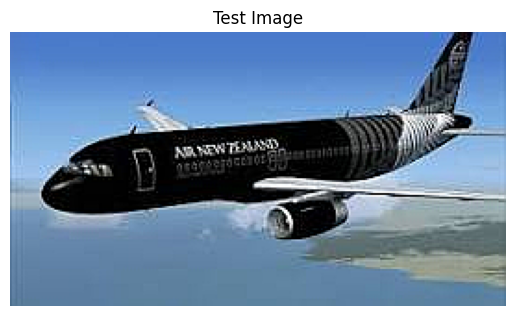

In [51]:
import matplotlib.pyplot as plt

test_image_np = image_pil.filter(ImageFilter.SHARPEN)
plt.imshow(test_image_np)
plt.title('Test Image')
plt.axis('off')  # Turn off axis
plt.show()

0
0
0


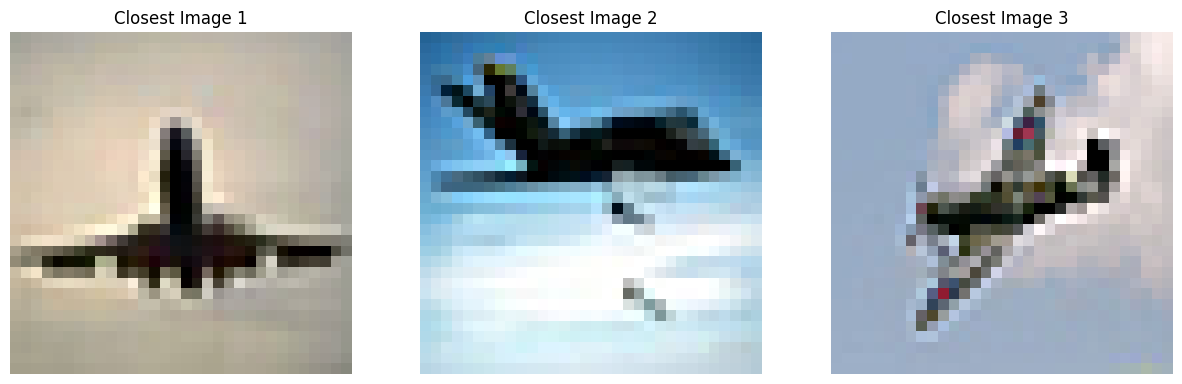

In [52]:
import cv2  # Assuming you are using OpenCV for image loading
from PIL import Image, ImageFilter

fig, axes = plt.subplots(1, len(closest_indices), figsize=(15, 5))

for i, idx in enumerate(closest_indices):
    closest_image =  Image.fromarray(train_x[idx])
    closest_image = closest_image.filter(ImageFilter.SHARPEN)
    print(train_y[idx])
    axes[i].imshow(closest_image)
    axes[i].set_title(f"Closest Image {i+1}")
    axes[i].axis('off')  # Turn off axis

plt.show()